In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin


In [2]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

from gensim.models import KeyedVectors

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Embedding, Dense, TimeDistributed, LSTM, GRU, Bidirectional, SimpleRNN, RNN
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
import nltk
nltk.download('treebank')
nltk.download('brown')
nltk.download('conll2000')
nltk.download('universal_tagset')

treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset = 'universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

[nltk_data] Error loading treebank: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading brown: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading conll2000: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading universal_tagset: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [4]:
tagged_sentences[11]

[('``', '.'),
 ('We', 'PRON'),
 ('have', 'VERB'),
 ('no', 'DET'),
 ('useful', 'ADJ'),
 ('information', 'NOUN'),
 ('on', 'ADP'),
 ('whether', 'ADP'),
 ('users', 'NOUN'),
 ('are', 'VERB'),
 ('at', 'ADP'),
 ('risk', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('said', 'VERB'),
 ('*T*-1', 'X'),
 ('James', 'NOUN'),
 ('A.', 'NOUN'),
 ('Talcott', 'NOUN'),
 ('of', 'ADP'),
 ('Boston', 'NOUN'),
 ("'s", 'PRT'),
 ('Dana-Farber', 'NOUN'),
 ('Cancer', 'NOUN'),
 ('Institute', 'NOUN'),
 ('.', '.')]

In [5]:
X = []
Y = []

for sentence in tagged_sentences:
    X_sentence=[]
    Y_sentence=[]
    for entity in sentence:
        X_sentence.append(entity[0])
        Y_sentence.append(entity[1])
    X.append(X_sentence)
    Y.append(Y_sentence)

In [6]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
print(num_words)
num_tags = len(set([word.lower() for sentence in Y for word in sentence]))
print(num_tags)
print("Total number of tagged sentences: {}".format(len(X)))

59448
12
Total number of tagged sentences: 72202


In [7]:
print("Length of first input seq : {}".format(len(X[0])))
print("Length of first input seq : {}".format(len(Y[0])))


Length of first input seq : 18
Length of first input seq : 18


In [8]:
# encode X

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)
X_encoded = word_tokenizer.texts_to_sequences(X)

In [9]:
# encode Y

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [10]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [6423, 24231, 2, 7652, 102, 170, 2, 47, 1898, 1, 269, 17, 7, 13230, 619, 1711, 2761, 3] 

Y:  [1, 1, 3, 11, 1, 6, 3, 2, 2, 5, 1, 4, 5, 6, 1, 1, 11, 3] 



In [11]:
# length of inputs and outputs
different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


In [12]:
# checking the length of the longest sentence
lengths=[len(seq) for seq in X_encoded]
print("Length of the longest sentence: {}".format(max(lengths)))

Length of the longest sentence: 271


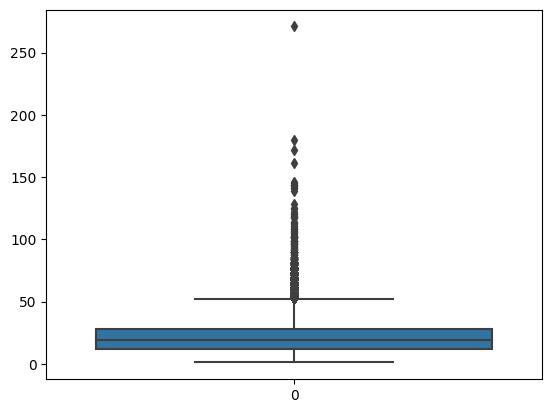

In [13]:
sns.boxplot(lengths)
plt.show()

In [15]:
# Padding and truncation
MAX_SEQ_LENGTH = 100

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [17]:
print(X_padded[0], "\n")
print(Y_padded[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0  6423 24231
     2  7652   102   170     2    47  1898     1   269    17     7 13230
   619  1711  2761     3] 

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  1  3 11  1  6  3  2  2  5  1  4  5  6
  1  1 11  3]


In [18]:
# assigning padded sequences to X and Y
X, Y = X_padded, Y_padded

In [19]:
# word2vec download link : https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
path = '../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'

# loading word2vec from gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [36]:
# effectiveness
word2vec.most_similar(positive=["Car", "SUV"], negative=["Sport"])

[('car', 0.6926775574684143),
 ('minivan', 0.6426631808280945),
 ('vehicle', 0.6272763609886169),
 ('pickup_truck', 0.5909958481788635),
 ('truck', 0.5877353549003601),
 ('Ford_Explorer', 0.565589189529419),
 ('sport_utility', 0.5576045513153076),
 ('suv', 0.5540929436683655),
 ('Honda_Accord', 0.5531286597251892),
 ('Nissan_Altima', 0.5530449748039246)]

In [38]:
# assigning word vectors from word2vec model

EMBEDDING_SIZE = 300 #300 Dimensional Vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

#creating an empty embedding matrix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# creating a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copying vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass
    

In [40]:
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (59449, 300)


In [45]:
embedding_weights[word_tokenizer.word_index['real']]

array([ 0.11523438, -0.08056641, -0.078125  ,  0.12060547, -0.19335938,
        0.20703125,  0.07763672, -0.09814453,  0.07470703,  0.18359375,
        0.01745605, -0.1953125 , -0.15820312,  0.04321289, -0.14550781,
        0.11962891,  0.15429688,  0.18847656, -0.14550781, -0.18164062,
       -0.13964844, -0.01293945, -0.11816406,  0.19335938, -0.00051498,
        0.01257324, -0.16113281,  0.04907227, -0.00157928,  0.00830078,
       -0.20605469, -0.05273438, -0.00375366,  0.02050781,  0.01513672,
       -0.09375   , -0.09130859,  0.0480957 ,  0.09326172,  0.17675781,
        0.12988281, -0.06835938,  0.20898438,  0.02441406,  0.01745605,
        0.06298828,  0.16992188,  0.08496094,  0.14746094, -0.04125977,
        0.0100708 ,  0.20410156, -0.2421875 , -0.10839844, -0.0067749 ,
       -0.04345703, -0.0100708 , -0.18359375,  0.3046875 , -0.15332031,
        0.01611328,  0.13183594,  0.10791016, -0.01324463, -0.02392578,
        0.05493164, -0.03198242,  0.04907227, -0.05200195, -0.04

In [46]:
# one-hot encoding Y
Y = to_categorical(Y)

In [47]:
print(Y.shape)

(72202, 100, 13)


In [50]:
# splitting entire data into training and testing sets
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [51]:
# splitting entire data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size = VALID_SIZE, random_state = 4)

In [52]:
# printing the number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (52165, 100)
Shape of output sequences: (52165, 100, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (9206, 100)
Shape of output sequences: (9206, 100, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (10831, 100)
Shape of output sequences: (10831, 100, 13)


**Uninitialised fixed embeddings**

In [55]:
# total number of tags
NUM_CLASSES = Y.shape[2]

**Using pre-trained embedding weights**

In [56]:
# creating the architecture

rnn_model = Sequential()

# creating embedding layer
rnn_model.add(Embedding(input_dim    = VOCABULARY_SIZE,     # number of unique words in data
                        output_dim   = EMBEDDING_SIZE,      # length of vector with which each word is represented
                        input_length = MAX_SEQ_LENGTH,      # length of input sequence
                        weights      = [embedding_weights], # word embedding matrix
                        trainable    = True                 # True, update the embeddings while training
))

# adding an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64,
                       return_sequences=True # True - return whole sequence; False - return single output of the end of the sequence
))

# adding time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation="softmax")))

In [57]:
rnn_model.compile(loss      = 'categorical_crossentropy',
                  optimizer = 'adam',
                  metrics   = ['acc'])

In [58]:
# summary of the model
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          17834700  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           23360     
                                                                 
 time_distributed (TimeDist  (None, 100, 13)           845       
 ributed)                                                        
                                                                 
Total params: 17858905 (68.13 MB)
Trainable params: 17858905 (68.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 150s 367ms/step - loss: 0.0038 - acc: 0.9988 - val_loss: 0.0420 - val_acc: 0.9895
Epoch 2/10
408/408 [==============================] - 150s 368ms/step - loss: 0.0033 - acc: 0.9990 - val_loss: 0.0441 - val_acc: 0.9892
Epoch 3/10
408/408 [==============================] - 152s 374ms/step - loss: 0.0030 - acc: 0.9991 - val_loss: 0.0463 - val_acc: 0.9892
Epoch 4/10
408/408 [==============================] - 154s 376ms/step - loss: 0.0028 - acc: 0.9991 - val_loss: 0.0478 - val_acc: 0.9891
Epoch 5/10
408/408 [==============================] - 152s 373ms/step - loss: 0.0026 - acc: 0.9992 - val_loss: 0.0492 - val_acc: 0.9892
Epoch 6/10
408/408 [==============================] - 154s 378ms/step - loss: 0.0024 - acc: 0.9993 - val_loss: 0.0508 - val_acc: 0.9890
Epoch 7/10
408/408 [==============================] - 153s 375ms/step - loss: 0.0022 - acc: 0.9993 - val_loss: 0.0524 - val_acc: 0.9889
Epoch 8/10
408/408 [============================

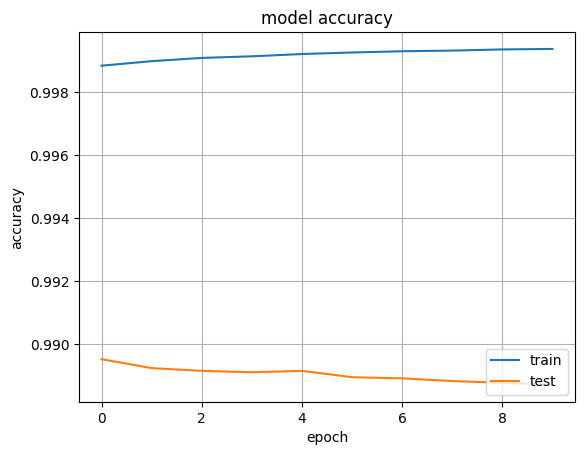

In [67]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [66]:
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 4s 12ms/step - loss: 0.0563 - acc: 0.9886
Loss: 0.0563100129365921,
Accuracy: 0.9886122941970825
